In [16]:
import numpy as np
from scipy import linalg

np.random.seed(42)

file = open("LR/1.txt", "r")

m = int(file.readline().strip())
n = int(file.readline().strip())

print(n)
print(m)

x_train = [[]] * n
y_train = [0] * n

for i in range(n):
    x_train[i] = list(map(int, file.readline().strip().split()))
    y_train[i] = x_train[i].pop()

test_size = int(file.readline().strip())

print(test_size)

x_test = [[]] * test_size
y_test = [0] * test_size

for i in range(test_size):
    x_test[i] = list(map(int, file.readline().strip().split()))
    y_test[i] = x_test[i].pop()

1164
428
256


In [17]:
def normalize(matrix):
    to_delete = []
    for i in range(len(matrix[0])):
        column_min, column_max = np.min(matrix[:, i]), np.max(matrix[:, i])
        if column_min == column_max:
            to_delete.append(i)
            continue
        matrix[:, i] = (matrix[:, i] - column_min) / (column_max - column_min)
    return np.delete(matrix, to_delete, 1)

def normalize_vector(y):
    column_min, column_max = np.min(y), np.max(y)
    return (y - column_min) / (column_max - column_min)

x_train = np.array(x_train, dtype=np.double)
y_train = np.array(y_train, dtype=np.double)
x_test = np.array(x_test, dtype=np.double)
y_test = np.array(y_test, dtype=np.double)

x_train = normalize(x_train)
x_test = normalize(x_test)
y_train = normalize_vector(y_train)
y_test = normalize_vector(y_test)

print(x_train.shape)
print(x_train)
print(y_train)

(1164, 268)
[[0.98495183 0.3803681  0.37894737 ... 0.96083813 0.95209657 1.        ]
 [0.93262423 0.30674847 0.30526316 ... 0.91845724 0.91134509 0.99523637]
 [0.99781398 0.60122699 0.6        ... 0.93281684 0.915604   0.94380125]
 ...
 [0.10155594 0.3006135  0.29473684 ... 0.17759087 0.19934945 0.10570429]
 [0.25506182 0.67484663 0.67368421 ... 0.28898677 0.3054264  0.01031114]
 [0.09064769 0.5398773  0.53684211 ... 0.13054697 0.14577707 0.        ]]
[0.         0.04305593 0.04853854 ... 0.90770319 0.93916542 1.        ]


In [18]:
def add_ones(matrix):
    b = np.ones((len(matrix), 1))
    return np.hstack((b, matrix))

x_train = add_ones(x_train)
x_test = add_ones(x_test)

print(x_train)

[[1.         0.98495183 0.3803681  ... 0.96083813 0.95209657 1.        ]
 [1.         0.93262423 0.30674847 ... 0.91845724 0.91134509 0.99523637]
 [1.         0.99781398 0.60122699 ... 0.93281684 0.915604   0.94380125]
 ...
 [1.         0.10155594 0.3006135  ... 0.17759087 0.19934945 0.10570429]
 [1.         0.25506182 0.67484663 ... 0.28898677 0.3054264  0.01031114]
 [1.         0.09064769 0.5398773  ... 0.13054697 0.14577707 0.        ]]


In [19]:
def lsm(t, matrix, ys):
    v, d, u = linalg.svd(matrix, full_matrices=False)
    d = np.diag(d)
    ones_matrix = np.diag(np.ones(min(len(matrix[0]), len(matrix))))
    f_plus = ((u @ linalg.inv(d @ d + t * ones_matrix)) @ d) @ np.transpose(v)
    params = np.matmul(f_plus, ys)
    return params

In [20]:
from math import sqrt

def mse(w, xi, y):
    y_pred = np.dot(xi, w)
    return (y - y_pred) ** 2

def smape(w, xi, y):
    y_pred = np.dot(xi, w)
    return 2 * abs(y - y_pred) / (abs(y) + abs(y_pred))

def mse_gradient(w, xi, y):
    y_pred = np.dot(xi, w)
    return 2 * (y_pred - y) * xi

def smape_gradient(w, xi, y):
    y_pred = np.dot(xi, w)
    sign = np.sign(y_pred - y)
    y_plus_y_pred = abs(y) + abs(y_pred)
    coef = 2 * (sign * y_plus_y_pred - abs(y - y_pred) * np.sign(y_pred)) / (y_plus_y_pred ** 2)
    return coef * xi

In [21]:
ITERATIONS = 2000
EPS = 0.0001

def changed(w_new, w):
    return abs(np.sum(np.absolute(w_new - w))) >= EPS

def stochastic_gradient_descent(step, alpha, t, loss_function, loss_grad, matrix, ys):
    features_cnt = len(matrix[0])
    objects_cnt = len(matrix)
    w = np.zeros(features_cnt)
    for i in range(features_cnt):
        w[i] = np.random.uniform(-1 / (2 * features_cnt), 1 / (2 * features_cnt))
    ls = 0

    for _ in range(ITERATIONS):
        index = np.random.randint(0, objects_cnt - 1)
        x = matrix[index]
        y = ys[index]
        w_new = (1 - step * t) * w - step * loss_grad(w, x, y)
        ls_new = (1 - alpha) * ls + alpha * (loss_function(w, x, y) + t / 2 * np.sum(np.square(w)))
        if not changed(w_new, w) or abs(ls_new - ls) < EPS:
            break
        w = w_new
        ls = ls_new

    return w, ls


In [22]:
def generate_param():
    return np.exp(np.random.uniform(-9, 0))

def calc_error(loss_function, w, dataset, ys):
    objects_cnt = len(dataset)
    total_error = 0
    for i in range(objects_cnt):
        total_error += loss_function(w, dataset[i], ys[i])
    return total_error / objects_cnt

In [23]:
EPOCHS = 600

lsm_error = 100
mse_error = 100
smape_error = 100

lsm_best_params = 0
mse_best_params = ()
smape_best_params = ()

for i in range(EPOCHS):
    t = generate_param()
    w = lsm(t, x_train, y_train)
    error = calc_error(mse, w, x_train, y_train)
    if i % 100 == 0:
        print("lsm:")
        print(f"    error: {error}")
    if error < lsm_error:
        lsm_error = error
        lsm_best_params = t

print("\n\n")
print("lsm:")
print(f"    best error: {lsm_error}")
print(f"    best params: t: {lsm_best_params}")

lsm:
    error: 0.2641369877057808
lsm:
    error: 0.26585183386305916
lsm:
    error: 0.26327839217639837
lsm:
    error: 0.2654690030602007
lsm:
    error: 0.2647613074676627
lsm:
    error: 0.2631477978805886



lsm:
    best error: 0.2629543403670821
    best params: t: 0.5801262504599148


In [24]:
for i in range(EPOCHS):
    step = generate_param()
    alpha = generate_param()
    t = generate_param()
    w, _ = stochastic_gradient_descent(step, alpha, t, mse, mse_gradient, x_train, y_train)
    error = calc_error(mse, w, x_train, y_train)
    if i % 100 == 0:
        print("gradient descent with mse:")
        print(f"    error: {error}")
    if error < mse_error:
        mse_error = error
        mse_best_params = (step, alpha, t)

print("gradient descent with mse:")
print(f"    best error: {mse_error}")
print(f"    best params: step: {mse_best_params[0]}, alpha: {mse_best_params[1]}, t: {mse_best_params[2]}")

gradient descent with mse:
    error: 0.2410951801681452


/var/folders/rq/sg13x7f91f9b_m60s_21b_540000gn/T/ipykernel_76246/607401958.py:5: RuntimeWarning: overflow encountered in double_scalars
  return (y - y_pred) ** 2
/Users/veronika/Desktop/machine-learning/2-lab/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/rq/sg13x7f91f9b_m60s_21b_540000gn/T/ipykernel_76246/607484715.py:20: RuntimeWarning: overflow encountered in square
  ls_new = (1 - alpha) * ls + alpha * (loss_function(w, x, y) + t / 2 * np.sum(np.square(w)))
/var/folders/rq/sg13x7f91f9b_m60s_21b_540000gn/T/ipykernel_76246/607484715.py:21: RuntimeWarning: invalid value encountered in double_scalars
  if not changed(w_new, w) or abs(ls_new - ls) < EPS:
/var/folders/rq/sg13x7f91f9b_m60s_21b_540000gn/T/ipykernel_76246/607484715.py:19: RuntimeWarning: invalid value encountered in subtract
  w_new = (1 - step * t) * w - step * loss_grad(w, x, y)
/var/fold

gradient descent with mse:
    error: nan


/var/folders/rq/sg13x7f91f9b_m60s_21b_540000gn/T/ipykernel_76246/607401958.py:13: RuntimeWarning: invalid value encountered in multiply
  return 2 * (y_pred - y) * xi


gradient descent with mse:
    error: nan
gradient descent with mse:
    error: nan
gradient descent with mse:
    error: nan
gradient descent with mse:
    error: 0.027870431972665956
gradient descent with mse:
    best error: 0.00016133582261983824
    best params: step: 0.006632563252681422, alpha: 0.04194858162055233, t: 0.019380507180653216


In [25]:
for i in range(EPOCHS):
    step = generate_param()
    alpha = generate_param()
    t = generate_param()
    w, _ = stochastic_gradient_descent(step, alpha, t, smape, smape_gradient, x_train, y_train)
    error = calc_error(smape, w, x_train, y_train)
    if i % 100 == 0:
        print("gradient descent with smape:")
        print(f"    error: {error}")
    if error < smape_error:
        smape_error = error
        smape_best_params = (step, alpha, t)

print("gradient descent with smape:")
print(f"    best error: {smape_error}")
print(f"    best params: step: {smape_best_params[0]}, alpha: {smape_best_params[1]}, t: {smape_best_params[2]}")

gradient descent with smape:
    error: 1.9065211456608164
gradient descent with smape:
    error: 0.2974048676153186
gradient descent with smape:
    error: 2.0
gradient descent with smape:
    error: 1.2641057036738654
gradient descent with smape:
    error: 2.0
gradient descent with smape:
    error: 0.2231208814371055
gradient descent with smape:
    best error: 0.01638726011616849
    best params: step: 0.00015228972536352362, alpha: 0.4254337081098078, t: 0.6230279630050719


In [26]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(x_train, y_train)
y_pred = model.predict(x_test)
print(model.score(x_test, y_test))

np.sum(np.square(y_pred - y_test)) / n

-14251.355814744582


92.88169966115336

In [27]:
if x_test.shape[0] < x_test.shape[1]:
    to_delete = set()
    while len(to_delete) < (x_test.shape[1] - x_test.shape[0]):
        index = np.random.randint(0, x_test.shape[1] - 1)
        to_delete.add(index)
    x_test = np.delete(x_test, list(to_delete), axis=1)

print(x_test.shape)

(256, 256)


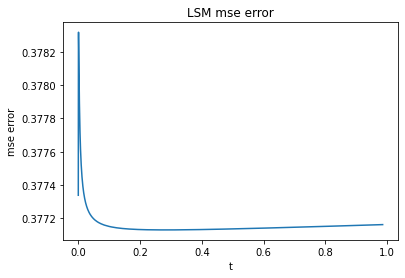

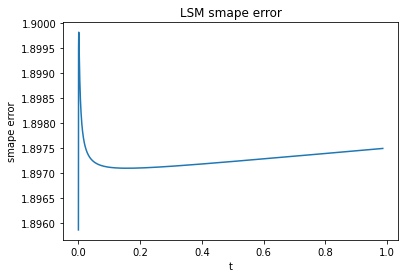

In [28]:
from matplotlib import pyplot as plt
plt.style.use({'figure.facecolor':'white'})

lsm_mse_errors = []
lsm_smape_errors = []
for i in range(EPOCHS):
    t = generate_param()
    w = lsm(t, x_test, y_test)
    lsm_mse_errors.append([t, calc_error(mse, w, x_test, y_test)])
    lsm_smape_errors.append([t, calc_error(smape, w, x_test, y_test)])

lsm_mse_errors.sort(key=lambda pr: pr[0])
lsm_smape_errors.sort(key=lambda pr: pr[0])
lsm_mse_errors = np.array(lsm_mse_errors)
lsm_smape_errors = np.array(lsm_smape_errors)

plt.figure(1)
plt.xlabel(xlabel="t")
plt.ylabel(ylabel="mse error")
plt.title(label="LSM mse error")
plt.plot(lsm_mse_errors[:, 0], lsm_mse_errors[:, 1])

plt.figure(2)
plt.xlabel(xlabel="t")
plt.ylabel(ylabel="smape error")
plt.title(label="LSM smape error")
plt.plot(lsm_smape_errors[:, 0], lsm_smape_errors[:, 1])

plt.show()

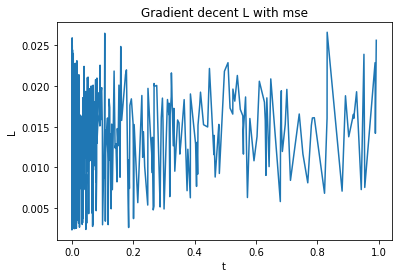

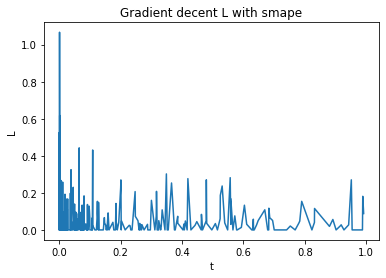

In [29]:
mse_errors = []
smape_errors = []
for i in range(EPOCHS):
    t = generate_param()
    _, mse_ls = stochastic_gradient_descent(
        mse_best_params[0],
        mse_best_params[1],
        t,
        mse,
        mse_gradient,
        x_train,
        y_train
    )
    mse_errors.append([t, mse_ls])
    _, smape_ls = stochastic_gradient_descent(
        smape_best_params[0],
        smape_best_params[1],
        t,
        smape,
        smape_gradient,
        x_train,
        y_train
    )
    smape_errors.append([t, smape_ls])

mse_errors.sort(key=lambda pr: pr[0])
smape_errors.sort(key=lambda pr: pr[0])
mse_errors = np.array(mse_errors)
smape_errors = np.array(smape_errors)

plt.figure(1)
plt.xlabel(xlabel="t")
plt.ylabel(ylabel="L")
plt.title(label="Gradient decent L with mse")
plt.plot(mse_errors[:, 0], mse_errors[:, 1])

plt.figure(2)
plt.xlabel(xlabel="t")
plt.ylabel(ylabel="L")
plt.title(label="Gradient decent L with smape")
plt.plot(smape_errors[:, 0], smape_errors[:, 1])

In [30]:
def calc_nrmse(w, xs, ys):
    y_pred = np.matmul(xs, w)
    y_mean = ys.mean()
    return sqrt(np.sum(np.square(ys - y_pred)) / np.sum(np.square(ys - y_mean)))

def calc_smape(w, xs, ys):
    return calc_error(smape, w, xs, ys)

lsm_w = lsm(lsm_best_params, x_test, y_test)
mse_w, _ = stochastic_gradient_descent(*mse_best_params, mse, mse_gradient, x_test, y_test)
smape_w, _ = stochastic_gradient_descent(*smape_best_params, smape, smape_gradient, x_test, y_test)

print("SMAPE:")
print(f"    lsm: {calc_smape(lsm_w, x_test, y_test)}")
print(f"    mse: {calc_smape(mse_w, x_test, y_test)}")
print(f"    smape: {calc_smape(smape_w, x_test, y_test)}")

print("NRMSE:")
print(f"    lsm: {calc_nrmse(lsm_w, x_test, y_test)}")
print(f"    mse: {calc_nrmse(mse_w, x_test, y_test)}")
print(f"    smape: {calc_nrmse(smape_w, x_test, y_test)}")


SMAPE:
    lsm: 1.8972708516239725
    mse: 0.24809789179019315
    smape: 0.026268959418939485
NRMSE:
    lsm: 3.5675727218011137
    mse: 1.0238907044579288
    smape: 0.07184559686419102
